In [1]:
from pylab import *
from warnings import warn
from scipy.linalg import solve_banded
import timeit
from scipy.stats import norm
from scipy.interpolate import interp1d

## Problem 1
### Part A: Gaussian Elimination
The variables and notation are taken from the problem sheet.
#### Step 1: Forward elimination:
First the forward elimination leading to the row echelon form (this is the same as finding the upper triangular matrix in the LU decomposition). To find each successive diagonal entry $b_i'$, we subtract an appropriately scaled multiple of the previous row, in order to eliminate the $a_i$:
$$b'_1 = b_1, \qquad b_i' = b_i - \frac{a_{i}c_{i-1}}{b_{i-1}}, i = 2,..,n.$$

The entries $d_i$ on the right hand side must then clearly transform successively with the same scaling:
$$d'_1 = d_1, \qquad d_i' = d_i - \frac{a_{i}d_{i-1}}{b_{i-1}}, i = 2,..,n.$$
#### Step 2: Back-substitution
We now have an upper triangular matrix, so we iteratively substitute backwards, solving for $x_i$:
$$x_n = \frac{d_n'}{b_n'}, \qquad x_i = \frac{d_i' - c_i x_{i+1}}{b_i'}$$ for $i = n-1,n-2,...,1.$

### Part B: Tridiagonal solver

In [2]:
def tridiag(a, b, c, d):
    n = len(d)
    ap, bp, cp, dp = a,b,c,d # modify copies of arrays instead
    # Forward elimination
    for i in range(1,n): # Arrays start at 0
        bp[i] = bp[i] - ap[i-1]*cp[i-1]/bp[i-1] # ap has to be reindexed in our notation
        dp[i] = dp[i] - ap[i-1]*dp[i-1]/bp[i-1]
        
    x = bp
    x[-1] = dp[-1]/bp[-1]
    
    # Back substitution
    for j in range(n-2, -1, -1):
        x[j] = (dp[j]-cp[j]*x[j+1])/bp[j]
        
    return x

### Part C: Comparison with Scipy's `solve_banded`

In [3]:
seed(2)
n = 200
d = rand(n)
a = -1*ones(n-1)
c = a
b = 4*ones(n) # modified b to make the matrix diagonally dominant, otherwise algorithm may be unstable

# Generating ab matrix for solve_banded
ab = zeros((3,n))
ab[0,1:] = c
ab[1,:] = b
ab[2,:-1] = a

# Checking result
isclose(solve_banded((1,1), ab, d) - tridiag(a,b,c,d),0)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [4]:
t1 = timeit.Timer('tridiag(a,b,c,d)', 'from __main__ import tridiag, a,b,c,d')
t2 = timeit.Timer('solve_banded((1,1), ab, d)', 'from __main__ import solve_banded, ab, d')

print("100 evaluations of 'tridiag' take", t1.timeit(number=100), "s.")
print("100 evaluations of solve_banded take", t2.timeit(number=100), "s.")

100 evaluations of 'tridiag' take 0.07018542196601629 s.
100 evaluations of solve_banded take 0.0032714299741201103 s.


## Problem 2
See PDF file in same folder.
## Problem 3
### Part A
Regrouping the terms in the explicit difference scheme yields:

$$V_n^{m-1} = aV_{n-1}^m + bV_n^m + cV_{n+1}^m$$
with $$a = \frac{\Delta t}{2}\left[\left(\frac{\sigma}{\Delta X}\right)^2 - \frac{r - \sigma^2 / 2}{\Delta X}  \right ],$$
$$b = 1 - r\Delta t - \left(\frac{\sigma}{\Delta X}\right)^2 \Delta t,$$
$$c = \frac{\Delta t}{2}\left[\left(\frac{\sigma}{\Delta X}\right)^2 + \frac{r - \sigma^2 / 2}{\Delta X}  \right ]$$ and we can iterate backwards to find $V_i^0 = V(X_i, 0),$ the call option price at time $t=0.$
##### Boundaries
The recursive computation above will be performed over a rectangular $(X, t)$ grid, and to be well defined everywhere we will need boundary conditions. At maturity $T, V(X, T) = C(S,T) = \max(S - K, 0).$ We then choose lower and upper bounds $S_{min}, S_{max}$ for the stock price in the time period under consideration. With $S_{min}$ assumed to be below the strike price, we have that $V(\log(S_{min}), t) = 0.$ Similarly, with $S_{max} \gg K$ we assume the call will be exercised. The value is then the stock price minus the present value of the strike price. See the hand-in.

In [5]:
def explicit_difference(r,sigma, S_0, K, T, time_steps):
    S_min = 1e-4 # Avoid log(0)
    S_max = 8*sigma*S_0*exp(T) # For typical stocks the price is very unlikely to move this far away
    N = time_steps # number of time steps
    time = linspace(0,T,N)
    dt = T/N
    X_min = log(S_min)
    X_max = log(S_max)
    XX = linspace(X_min, X_max, N)
    dx = (X_max - X_min)/N

    # Boundary conditions
    IC = [max(exp(XX[i])-K,0) for i in range(len(XX))]
    LB = zeros(N)
    UB = S_max - K*exp(-r*(T - time))
    
    alpha = dt/(dx)**2
    
    if alpha > 0.5:
        warn("The solution is unstable; dt/(dx)**2 > 0.5.")
    
    a = 0.5*(alpha*sigma**2 - dt*(r - 0.5*sigma**2)/dx)
    b = 1 - alpha*sigma**2 - r*dt
    c = 0.5*(alpha*sigma**2 + dt*(r - 0.5*sigma**2)/dx)
    
    V = zeros((N,N))
    V[:,-1] = IC
    V[0,:] = LB
    V[-1,:] = UB
    
    # Iterate backwards
    for j in range(N-1, -1, -1):
        V[1:-1,j-1] = a*V[:-2,j] + b*V[1:-1,j] + c*V[2:,j] 
        
    f = interp1d(XX, V[:,0], kind='cubic')
    return float(f(log(S_0)))

explicit_difference(0.03, 0.5, 500,400,1,150)

154.69861898388828

Comparing with the Black-Scholes price:

In [6]:
def black_scholes(r, sigma, S, K, T):
    x = (log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*sqrt(T))
    return S*norm.cdf(x) - K*exp(-r*T)*norm.cdf(x - sigma*sqrt(T))
black_scholes(0.03, 0.5, 500,400,1)

154.28305595547587

### Part B:
When $\frac{\Delta t}{(\Delta X)^2} > \frac{1}{2},$ the explicit interpolation becomes unstable:

In [7]:
explicit_difference(0.03, 0.5, 500,400,1,1500)

<ipython-input-5-9a427b3010ef>:20: UserWarning: The solution is unstable; dt/(dx)**2 > 0.5.
  warn("The solution is unstable; dt/(dx)**2 > 0.5.")


-3.293279575190223e+199

## Part C
After regrouping terms we find $$V_n^{m+1} = aV_{n-1}^m + bV_n^m + cV_{n+1}^m$$ with $$a = \frac{\Delta t}{2}\left[-\left(\frac{\sigma}{\Delta X}\right)^2 + \frac{r - \sigma^2 / 2}{\Delta X}  \right ],$$
$$b = 1 + r\Delta t + \left(\frac{\sigma}{\Delta X}\right)^2 \Delta t,$$
$$c = -\frac{\Delta t}{2}\left[\left(\frac{\sigma}{\Delta X}\right)^2 + \frac{r - \sigma^2 / 2}{\Delta X}  \right ]$$  

In [8]:
def implicit_difference(r,sigma, S_0, K, T, time_steps):
    S_min = 1e-4 # Avoid log(0)
    S_max = 8*sigma*S_0*exp(T) # For normal stocks the price is very unlikely to move 8 standard deviations away
    N = time_steps # number of time steps
    time = linspace(0,T,N)
    dt = T/N
    X_min = log(S_min)
    X_max = log(S_max)
    XX = linspace(X_min, X_max, N)
    dx = (X_max - X_min)/N

    #Initial condition
    IC = [max(exp(XX[i])-K,0) for i in range(len(XX))]
    
    alpha = dt/(dx)**2
    
    a = 0.5*(-alpha*sigma**2 + dt*(r - 0.5*sigma**2)/dx)
    b = 1 + alpha*sigma**2 + r*dt
    c = -0.5*(alpha*sigma**2 + dt*(r - 0.5*sigma**2)/dx)
    
    # Build tridiagonal matrix for solve_banded

    A = full(N - 1, a)
    B = r_[a+b, full(N-1, b)]
    C = full(N - 1, c)
    
    ab = zeros((3,N))
    ab[0,1:] = C
    ab[1,:] = B
    ab[2,:-1] = A
    
    option_prices = IC
    
    while N > 0:   
        option_prices = solve_banded((1,1), ab, option_prices)
        N -= 1
        
    # The interpolation method below does not vectorize well, so instead we just choose the closest value to log(S_0), which is not as accurate
    
    #f = interp1d(XX, option_prices, kind='cubic')
    #return float(f(log(S_0)))
    
    def closest_index(array, number):
        return abs(array - number).argmin()
    
    return option_prices[closest_index(XX, log(S_0))]

implicit_difference(0.03, 0.5, 500,400,1,150)

153.13835401825057

Unlike the explicit difference scheme, even when the time step is relatively large compared to the log-stock step, the implicit difference scheme remains stable. Here, since we are using the same number of meshpoints $N$ for $X$ and $t,$ $\frac{\Delta t}{(\Delta X)^2}$ grows with $N.$

In [9]:
# Check stability, compare with same parameters given to explicit_difference in Part B
implicit_difference(0.03, 0.5, 500,400,1,5000)

153.96012803725733

### Part D: Order of Convergence

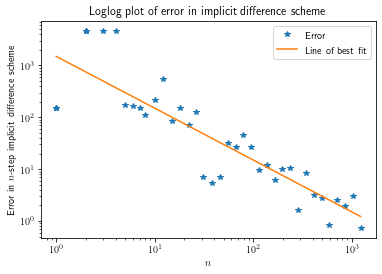

In [10]:
def error(n):
    return abs(black_scholes(0.03, 0.5, 500,400,1) - implicit_difference(0.03, 0.5, 500,400,1,n))

error_vec = vectorize(error)

x = array(1.2**arange(1,40),dtype=int)

figure()
rc('text', usetex=True)
title('Loglog plot of error in implicit difference scheme')
xlabel(r'$n$')
ylabel(r'Error in $n$-step implicit difference scheme')
loglog(x,error_vec(x),'*',label='Error')
loglog(x,1500/x,label='Line of best fit') # fit a straight line, done by hand
legend()
show()

We roughly obtain a straight line with slope -1, suggesting the order of convergence is 1.